# MNIST classification with kNN classifier

# Author: Panov Aleksandr 381903-3m

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Load MNIST dataset and prepare data

Ссылка на датасет: https://www.kaggle.com/oddrationale/mnist-in-csv

Предполагается, что данные лежат в папке data.

In [2]:
data_train = pd.read_csv("./data/mnist_train.csv", sep = ',', engine = 'python')
data_test = pd.read_csv("./data/mnist_test.csv", sep = ',', engine = 'python')

In [3]:
mini_train = data_train.sample(frac=0.3, random_state=2)
mini_test = data_test.sample(frac=0.2, random_state=2)

In [4]:
def getXY(data):
    return data.drop(('label'), axis = 1), data['label']

In [5]:
x_train, y_train = getXY(data_train)
x_test, y_test = getXY(data_test)
print(x_train.shape, x_test.shape)

x_mini_train, y_mini_train = getXY(mini_train)
x_mini_test, y_mini_test = getXY(mini_test)
print(x_mini_train.shape, x_mini_test.shape)

(60000, 784) (10000, 784)
(18000, 784) (2000, 784)


In [6]:
def get_image(data, index):
    return data.values[index].reshape(28, 28)

def plot_image(image):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(image, cmap="gray_r")
    fig.colorbar(im)

7 8 8


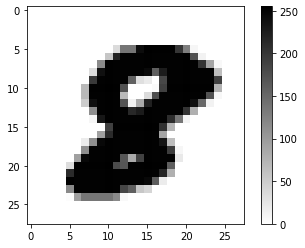

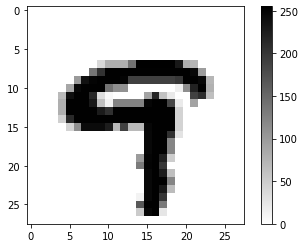

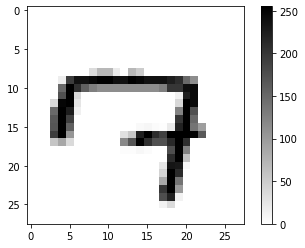

In [7]:
plot_image(get_image(x_mini_test,0))
plot_image(get_image(x_mini_test,1000))
plot_image(get_image(x_mini_test,1001))
test_img_8 = x_mini_test.values[0]
test_img_9 = x_mini_test.values[1000]
test_img_7 = x_mini_test.values[1001]
print(y_test.iloc[0], y_mini_test.iloc[0], y_mini_test.values[1])

## 2. Distance functions
Для улучшения производительности использовался пакет numba.
Реализованы метрики L_1 и L_2

In [8]:
from numba import njit, jit, prange
from collections import Counter
import math

@njit(cache=True)
def metric_l1(x, y):
    return np.sum(np.abs(x-y))

@njit(cache=True, nogil=True, parallel=True) 
def get_dist(metric, x, X_Train):
    dist_list = np.zeros(len(X_Train), dtype=np.float32)
    if metric == 'euclidean':
        #dist_list = np.sqrt(np.sum((X_Train-x)**2, axis=1))
        for idx in prange (len(dist_list)):
            for a, b in zip(x, X_Train[idx]):
                dist_list[idx] += (a-b)*(a-b)
                #dist_list[idx] = math.sqrt(dist_list[idx])
    elif metric == 'manhattan':
        for idx in prange (len(dist_list)):#prange
            dist_list[idx] = metric_l1(X_Train[idx], x)
    return dist_list

@njit(cache=True)
def get_kmain(dist_list, k):
    k_main = np.zeros(k, dtype=np.int64)#k_main = np.argpartition(dist_list, k)
    vmax = np.amax(dist_list)
    for i in range(k):
        indx = np.argmin(dist_list)
        k_main[i] = indx
        dist_list[indx] = vmax + 100.0
        vmax += 1.0
    return k_main

def get_counter(Y_Train, kmain):
    tmp = [Y_Train[i] for i in kmain]
    return Counter(tmp)

## 3. kNN classifier implementation

In [9]:
class KNeighborsClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean', n_classes=10):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.n_classes = n_classes
        
    def fit(self, X, Y):
        self.X_Train = X.values
        self.Y_Train = Y.values
        
    def predict_proba(self, x):
        dist_list = get_dist(self.metric, x, self.X_Train)
        k_main = get_kmain(dist_list, self.n_neighbors)
        counter = get_counter(self.Y_Train, k_main)
        return [counter[x]/self.n_neighbors for x in range(self.n_classes)]
        
    def _predict(self, x):
        dist_list = get_dist(self.metric, x, self.X_Train)
        k_main = get_kmain(dist_list, self.n_neighbors)
        return get_counter(self.Y_Train, k_main).most_common(1)[0][0]
    
    def predict(self, X):
        return [self._predict(x) for x in X.values]#list(map(self._predict, X.values))

## 4. Check correctness

### K = 1
При k = 1 и евклидовой метрике точность реализованого метода совпадает с точностью knn из sklearn, при тех же параметрах.

In [10]:
k = 1
metr='euclidean'

In [12]:
import time
start_time = time.time()
firsKNN = KNeighborsClassifier(n_neighbors = k, metric=metr)
firsKNN.fit(x_mini_train, y_mini_train)
mini_predict = firsKNN.predict(x_mini_test)
print("--- %s seconds ---" % (time.time() - start_time))

err_test_mini = np.mean(y_mini_test != mini_predict)
print(err_test_mini)

--- 34.603232860565186 seconds ---
0.0425


In [13]:
from sklearn.neighbors import KNeighborsClassifier as KNN 

knn = KNN(n_neighbors = k, metric=metr, n_jobs = 8)
knn.fit(x_mini_train, y_mini_train)
start_time = time.time()
mini_predict = knn.predict(x_mini_test)
print("--- %s seconds ---" % (time.time() - start_time))
err_test_mini = np.mean(y_mini_test != mini_predict)
print(err_test_mini)

--- 5.633469820022583 seconds ---
0.0425


### K = 5
При k = 5 и евклидовой метрике точность реализованого метода совпадает с точностью knn из sklearn, при тех же параметрах. Также совпадают результаты метода predic_proba.

In [14]:
k = 5

In [15]:
start_time = time.time()
firsKNN = KNeighborsClassifier(n_neighbors=k, metric=metr)
firsKNN.fit(x_mini_train, y_mini_train)
mini_predict = firsKNN.predict(x_mini_test)
print("--- %s seconds ---" % (time.time() - start_time))
err_test_mini = np.mean(y_mini_test != mini_predict)
print(err_test_mini)

--- 43.46285128593445 seconds ---
0.0385


In [16]:
knn = KNN(n_neighbors = k, metric=metr, n_jobs = 8)
knn.fit(x_mini_train, y_mini_train)

mini_proba1 = firsKNN.predict_proba(test_img_7)
print(mini_proba1)
mini_proba2 = knn.predict_proba([test_img_7])
print(mini_proba2[0])
print(np.array_equal(mini_proba1, mini_proba2[0]))


mini_proba1 = firsKNN.predict_proba(test_img_8)
print(mini_proba1)
mini_proba2 = knn.predict_proba([test_img_8])
print(mini_proba2[0])
print(np.array_equal(mini_proba1, mini_proba2[0]))


mini_proba1 = firsKNN.predict_proba(test_img_9)
print(mini_proba1)
mini_proba2 = knn.predict_proba([test_img_9])
print(mini_proba2[0])
print(np.array_equal(mini_proba1, mini_proba2[0]))


[0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.8, 0.0, 0.0]
[0.  0.  0.  0.  0.2 0.  0.  0.8 0.  0. ]
True
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
True
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
True


## 5. Define features
1. Текст на картинке удобно бинаризировать, посмотрим как на это отреагирует knn
2. Попробуем посчитать "vertical and horizontal projection histogram" результат и в качестве фичи добавить к данным

In [17]:
def tobin(val, threshold = 8):
    if val >= threshold:
        return 1
    return 0
f_tobin = np.vectorize(tobin)
bin_x_mini_train = pd.DataFrame(f_tobin(x_mini_train.values))
bin_x_mini_test = pd.DataFrame(f_tobin(x_mini_test.values))
test_img_bin = bin_x_mini_test.values[0]

In [18]:
coeff = 6
def hor(x):
    return x.reshape(28, 28).sum(axis=1) // coeff

def ver(x):
    return x.reshape(28, 28).sum(axis=0) // coeff
n = 28 + 28 + 784
bin_train_features = pd.DataFrame(np.zeros(shape=(len(bin_x_mini_train), n), dtype=np.int64), columns = range(n), )
bin_test_features = pd.DataFrame(np.zeros(shape=(len(bin_x_mini_test), n), dtype=np.int64), columns = range(n))

train_features = pd.DataFrame(np.zeros(shape=(len(bin_x_mini_train), n), dtype=np.int64), columns = range(n), )
test_features = pd.DataFrame(np.zeros(shape=(len(bin_x_mini_test), n), dtype=np.int64), columns = range(n))

def add_features(features, X):
    for i in range(len(X)):
        res = X.values[i]
        features.values[i] = np.concatenate((res, hor(res), ver(res)))
add_features(bin_train_features, bin_x_mini_train)
add_features(bin_test_features, bin_x_mini_test)

add_features(train_features, x_mini_train)
add_features(test_features, x_mini_test)

## 6. Find hyper-parameters

In [19]:
k = 1
metr='manhattan'

In [20]:
start_time = time.time()
firsKNN = KNeighborsClassifier(n_neighbors=k, metric=metr)
firsKNN.fit(bin_x_mini_train, y_mini_train)
mini_predict = firsKNN.predict(bin_x_mini_test)
print("--- %s seconds ---" % (time.time() - start_time))
err_test_mini = np.mean(y_mini_test != mini_predict)
print(err_test_mini)

--- 22.78796672821045 seconds ---
0.0455


In [21]:
k = 5
metr='manhattan'

In [22]:
start_time = time.time()
firsKNN = KNeighborsClassifier(n_neighbors=k, metric=metr)
firsKNN.fit(bin_x_mini_train, y_mini_train)
mini_predict = firsKNN.predict(bin_x_mini_test)
print("--- %s seconds ---" % (time.time() - start_time))
err_test_mini = np.mean(y_mini_test != mini_predict)
print(err_test_mini)

--- 21.77993679046631 seconds ---
0.0405


In [23]:
k = 6
metr='euclidean'#manhattan

In [24]:
start_time = time.time()
fknn = KNeighborsClassifier(n_neighbors=k, metric=metr)
fknn.fit(train_features, y_mini_train)
mini_predict = fknn.predict(test_features)
print("--- %s seconds ---" % (time.time() - start_time))
err_test_mini = np.mean(y_mini_test != mini_predict)
print(err_test_mini)

--- 7.162691354751587 seconds ---
0.035


### 6.1 Using full training dataset

In [25]:
res_train_features = pd.DataFrame(np.zeros(shape=(len(data_train), n), dtype=np.int64), columns = range(n), )
res_test_features = pd.DataFrame(np.zeros(shape=(len(data_test), n), dtype=np.int64), columns = range(n))
add_features(res_train_features, x_train)
add_features(res_test_features, x_test)

In [26]:
start_time = time.time()
fknn = KNeighborsClassifier(n_neighbors=k, metric=metr)
fknn.fit(res_train_features, y_train)
predict = fknn.predict(res_test_features)
print("--- %s seconds ---" % (time.time() - start_time))
err_test_mini = np.mean(y_test != predict)
print(err_test_mini)

--- 100.75783729553223 seconds ---
0.0291


In [27]:
start_time = time.time()
predict = fknn.predict(res_train_features)
print("--- %s seconds ---" % (time.time() - start_time))
err_test_mini = np.mean(y_train != predict)
print(err_test_mini)

--- 631.5681538581848 seconds ---
0.015166666666666667


## 7. Results
1. k: 6
2. Distance function: euclidean
3. Features: Projection Histograms

### The best model test accuracy:
Test: 97.09%

Train: 98.48%
###  Why such model parameters are the best?

В данной работе наименьшая ошибка получилась равной 2.91%. Данный результат был достигнут с евклидовой метрикой, числом соседей k = 6, с добавлением фичи Projection Histograms. При использовании других параметров или бинаризации изображения, ошибка была больше. Для улучшения результата имеет смысл попробовать другие фичи, а также поэксперементировать с предообработкой данных.